This code is based on:<br>
https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf<br>
Adapted and updated by me.<br>
This program implements baseline_tolentino with a 35 values training data set to test if it can learn the trivial predictor.

Este código está basado en:<br>
https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf<br>
Adaptado y actualizado por mi.<br>
Este programa implementa baseline_tolentino con 35 datos de entrenamiento para verificar si aprende el predictor trivial.

#### 1 ANN Univariate Time Series Forecast
#### 1 ANN Predicción de serie de tiempo de una variable
#### baseline_tolentino_trivial.ipynb
Sliding window/Ventana deslizante: 30<br>
Input scale/Escala de entrada: [0, 1]<br>
Optimizer/Optimizador: adagrad<br>
Loss/Pérdida: LogCosh<br>
Data/Datos: 2000-01-03 - 2019-03-14<br>
Train Test split/Corte para prueba: 35<br>
Hidden neurons/Capa oculta: 12 ReLU<br>
Output layer/Capa de salida: 1 Linear<br>
Epochs: 100<br>
Batch size/Tamaño de lote: 1

##### 1.1 Environment setup
##### 1.1 Configuración del ambiente

In [ ]:
# Not needed on colab
# No hace falta en colab
%matplotlib inline
# import libraries and functions
# importar librerías y funciones
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy.random import seed
from tensorflow.random import set_seed
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

##### 1.2 Ensuring reproducibility of results by seeding both numpy and tensorflow random generators.
##### 1.2 Asegura la reproducibilidad de los resultados fijando la semilla de los generadores aleatorios de numpy  y tensorflow.

In [ ]:
seed(314159)
set_seed(160669)

##### 1.3 Download CSV data from source
##### 1.3 Bajar el CSV de la fuente
I downloaded the data from Yahoo finance and prepared the file baseline_tolentino.csv with the same data as the original thesis.

Yo bajé los datos a mano y prepare el archivo baseline_tolentino.csv con los mismos datos usados en la tesis original.

In [ ]:
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_tolentino.csv",
    "https://raw.githubusercontent.com/jmacostap/webstore/master/"+
    "baseline_tolentino.csv",
    cache_dir="/content",
    )

335872/328946 [==============================] - 0s 0us/step


##### 1.4 Data Preparation and Display
##### 1.4 Preparación de datos y Despliegue
The following cells handle importing the data into an adequate format, and doing initial exploration, by visualising available data and plotting its graph, as well as dropping features that will not be considered for the purpose of this experiment.

Las siguientes celdas manejan el formato y la exploración inicial de los datos mediante la visualización gráfica y purgan los datos innecesarios para este experimento.

In [ ]:
# load data into a Pandas dataframe
# cargar los datos en un dataframe de Pandas
df = pd.read_csv(path_to_downloaded_file)
print(len(df), "lines read")
print(df.head())
print(df.tail())

4829 lines read
         Date         Open         High          Low        Close      Volume
0  2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   931800000
1  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1009000000
2  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1085500000
3  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1092300000
4  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1225200000
            Date         Open  ...        Close      Volume
4824  2019-03-08  2730.790039  ...  2743.070068  3423130000
4825  2019-03-11  2747.610107  ...  2783.300049  3749030000
4826  2019-03-12  2787.340088  ...  2791.520020  3414230000
4827  2019-03-13  2799.780029  ...  2810.919922  3766150000
4828  2019-03-14  2810.379883  ...  2808.479980  3469730000

[5 rows x 6 columns]


In [ ]:
# save the split point before dropping the Date column
# salva el punto de corte antes de borrar la columna de fecha
split = df[df['Date'].str.match('2016-01-04')].index.values[0]
split = 35 # use only the first 35 data points to train this model
# se usan solo los primeros 35 puntos para entrenar
split

35

In [ ]:
# drop columns that will not be used
# eliminar columnas que no se van a usar
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
# convert date into a datetime index just for the next graph
# convertir la columna de fecha en un índice para hacer el gráfico
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head(10)

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
2000-01-10,1457.599976
2000-01-11,1438.560059
2000-01-12,1432.250000
2000-01-13,1449.680054


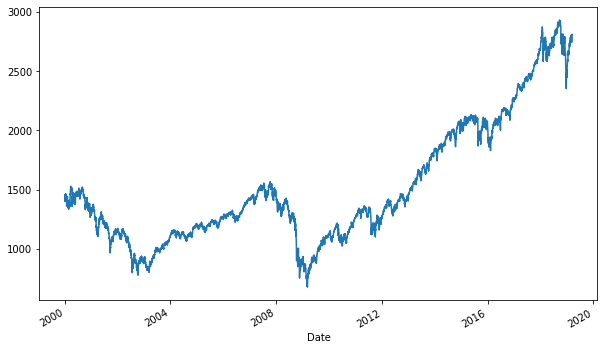

In [ ]:
# show the loaded data
# mostrar los datos cargados
df['Close'].plot(figsize=(10, 6))
plt.show()

##### 1.5 Data Pre-processing
##### 1.5 Pre-procesamiento de datos
The following cells split the resulting dataset into training and testing data, and scales the results for optimal predictions.

Estas celdas separan los datos en entrenamiento y prueba, y escalan los resultados para optimizar las predicciones.

In [ ]:
# split the data and convert to 2D Numpy Arrays for MinMaxScaler
# separar los datos y convertir a arreglos Numpy para MinMaxScaler
train = df.iloc[:split].values.reshape(-1,1)
test = df.iloc[split:].values.reshape(-1,1)

In [ ]:
# scale data
# escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
# it must fit using only train data to avoid dataleak
# debe escalar usando solo la data de entrenamiento para evitar dataleak
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

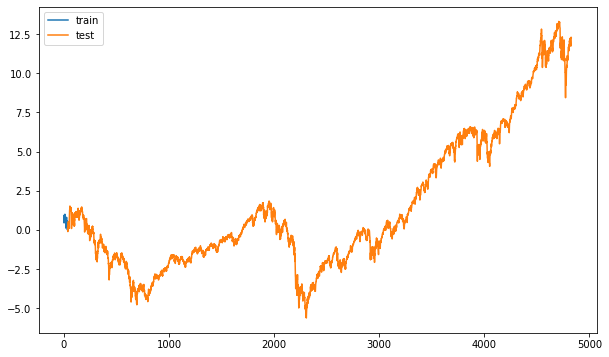

In [ ]:
# show the splitted and scaled data in a graph
# mostrar datos separados y escalados
plt.figure(figsize=(10, 6))
plt.plot(range(split), train_scaled)
plt.plot(range(split, len(df)), test_scaled)
plt.legend(['train','test'])
plt.show()

In [ ]:
# prepare time series and targets for Keras
# preparar la serie de tiempo y los objetivos para Keras
def prepare_time_series(time_series, targets, window):
    """
    like tf.keras.preprocessing.sequence.TimeseriesGenerator
    except the batches
    time_series[0:window] -> targets[window]
    In the most basic case time_series and targets are the same array

    como tf.keras.preprocessing.sequence.TimeseriesGenerator
    excepto los lotes
    time_series[0:window] -> targets[window]
    En el caso más básico time_series and targets son el mismo arreglo
    """
    data_set_length = len(time_series) - window
    X = np.empty((data_set_length, window))
    Y = np.empty((data_set_length, 1))
    for i in range(data_set_length):
        X[i, :] = time_series[i:(i + window)]
        Y[i, 0] = targets[i + window]
    return X, Y

###### Hyperparameters
###### Hiperparámetros

In [ ]:
# the idea is to group the configurable parameters in one place
# la idea es agrupar los parámetros configurables en un solo sitio
p = {
    "window": 30,
    "neurons": 12,
    "activation": "relu",  # for the hidden layer/capa oculta
    "output_activation": "linear",  # for the output layer/capa de salida
    "loss": "mse",  # could be/puede ser logcosh, mae, mape or mse
    "optimizer": "nadam",  # could be/puede ser sgd, rmsprop, adam, adadelta,
    # adagrad, adamax, nadam, or ftrl
    # o una instancia de una clase con parámetros
    # or a class instance with parameters like
    # tf.keras.optimizers.SGD(
    #    learning_rate=0.3,
    #    momentum=0.2,
    #    nesterov=False),
    "epochs": 100,  # training epochs/épocas de entrenamiento
    "batch_size": 1,
    "shuffle": True,  # the training data/mezclar los datos de entrenamiento
    "verbose": 1,  # verbose training/entrenamiento verboso
    }

In [ ]:
# prepare train and test data for Keras
# prepara los datos para Keras
X_train, y_train = prepare_time_series(
    train_scaled.flat, train_scaled.flat, p['window'])
X_test, y_test = prepare_time_series(
    test_scaled.flat, test_scaled.flat, p['window'])
print("X", X_train)
print("y", y_train)

X [[0.91659627 0.44792585 0.470519   0.48177353 0.80110834 0.93658622
  0.77666763 0.72366867 0.87006583 1.         0.91592471 0.92230812
  0.83554453 0.80018455 0.46564787 0.53704042 0.4871491  0.44070273
  0.11817622 0.40626551 0.53074107 0.52939693 0.66252282 0.65748354
  0.65639162 0.80320812 0.55115037 0.59415383 0.34461624 0.36830131]
 [0.44792585 0.470519   0.48177353 0.80110834 0.93658622 0.77666763
  0.72366867 0.87006583 1.         0.91592471 0.92230812 0.83554453
  0.80018455 0.46564787 0.53704042 0.4871491  0.44070273 0.11817622
  0.40626551 0.53074107 0.52939693 0.66252282 0.65748354 0.65639162
  0.80320812 0.55115037 0.59415383 0.34461624 0.36830131 0.47001559]
 [0.470519   0.48177353 0.80110834 0.93658622 0.77666763 0.72366867
  0.87006583 1.         0.91592471 0.92230812 0.83554453 0.80018455
  0.46564787 0.53704042 0.4871491  0.44070273 0.11817622 0.40626551
  0.53074107 0.52939693 0.66252282 0.65748354 0.65639162 0.80320812
  0.55115037 0.59415383 0.34461624 0.3683013

##### 1.6 Model definition and training
##### 1.6 Definición del modelo y entrenamiento
The following cells define the ANN model based on the hyperparameters in p.
Aquí se define el modelo de la RNA en base a los hiperparámetros en p.

In [ ]:
ann = Sequential()
ann.add(Dense(units=p['neurons'],
              input_dim=p['window'],
              activation=p['activation']))
ann.add(Dense(units=1, activation=p['output_activation']))
ann.compile(loss=p['loss'], optimizer=p['optimizer'])

In [ ]:
history = ann.fit(x=X_train,
                  y=y_train,
                  epochs=p['epochs'],
                  batch_size=p['batch_size'],
                  verbose=p['verbose'],
                  validation_split=0.0, # use all data for training
                  # usa todos los datos para entrenar
                  shuffle=p['shuffle'])

Epoch 1/100
5/5 [==============================] - 1s 3ms/step - loss: 0.2472
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1462
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1609
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0762
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0638
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0501
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0861
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 11/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0379
Epoch 12/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0486
Epoch 13/100
5/5 [==============================] - 0s 4ms/st

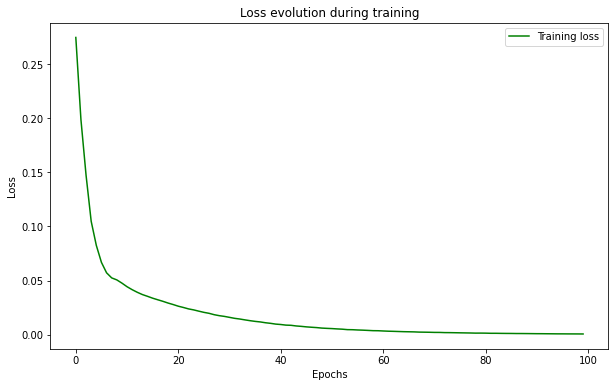

In [ ]:
# graph Train and Validation loss evolution
# graficar la evolución del error de entrenamiento y validación
skip = 0  # Avoid autoscale issues
# si los primeros valores son muy altos se pueden eliminar del gráfico
# para evitar que afecten la escala
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'][skip:], 'g', label='Training loss')
#plt.plot(history.history['val_loss'][skip:], 'b', label='Validation loss')
plt.title('Loss evolution during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

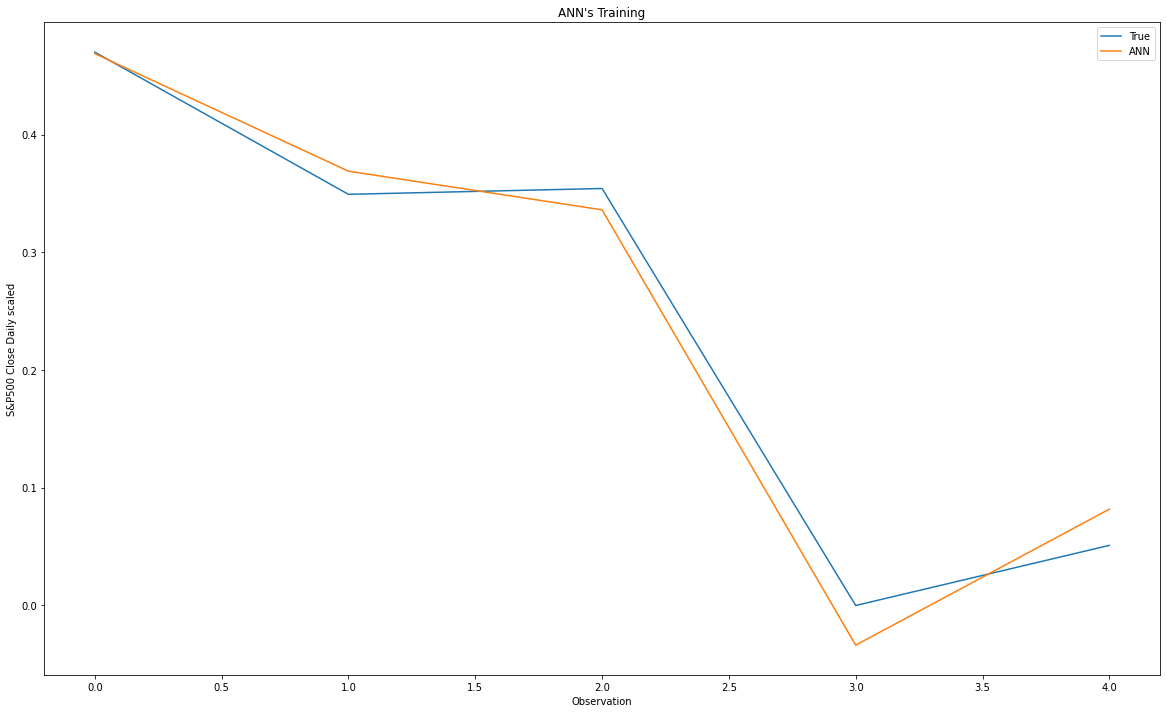

In [ ]:
y_train_pred_ann = ann.predict(X_train)
plt.figure(figsize=(20, 12))
plt.plot(y_train, label='True')
plt.plot(y_train_pred_ann, label='ANN')
plt.title("ANN's Training")
plt.xlabel('Observation')
plt.ylabel('S&P500 Close Daily scaled')
plt.legend()
plt.show()

##### 1.7 Prediction and Accuracy
##### 1.7 Predicción y Exactitud
The following cells use the trained model with the test data. This result is outputted in the form of an R2 score, for both the train dataset and the test dataset. The loss is also calculated. The last cell will plot the resulting predictions, alongside the ground truth. At this point, data has not been
scaled back to its original state.

A continuación se prueba el modelo entrenado con los datos de prueba y se calcula el índice R2 y la pérdida. Luego se grafica la predicción contra el valor real. Los datos no han sido devueltos a su escala original.

In [ ]:
y_pred_test_ann = ann.predict(X_test)
print("R2 score of a trivial predictor on train data:\t{:0.8f}".format(r2_score(y_train[1:], y_train[:-1])))
print("R2 score of a trivial predictor on test data:\t{:0.8f}".format(r2_score(y_test[1:], y_test[:-1])))
print("MSE of a trivial predictor on test data:\t{:0.8f}".format(mean_squared_error(y_test[1:], y_test[:-1])))
print("The R2 score on the Train set is:\t{:0.8f}".format(r2_score(y_train, y_train_pred_ann)))
print("The R2 score on the Test set is:\t{:0.8f}".format(r2_score(y_test, y_pred_test_ann)))
print("MSE of the trained ANN on test data:\t{:0.8f}".format(mean_squared_error(y_test, y_pred_test_ann)))

R2 score of a trivial predictor on train data:	-0.32459427
R2 score of a trivial predictor on test data:	0.99907766
MSE of a trivial predictor on test data:	0.01798168
The R2 score on the Train set is:	0.98364459
The R2 score on the Test set is:	0.76432026
MSE of the trained ANN on test data:	4.59379353


In [ ]:
ann_test = ann.evaluate(x=X_test,
                        y=y_test,
                        batch_size=1)
print("ANN: {}".format(ann_test))


4764/4764 [==============================] - 4s 747us/step - loss: 4.5938
ANN: 4.5937981605529785


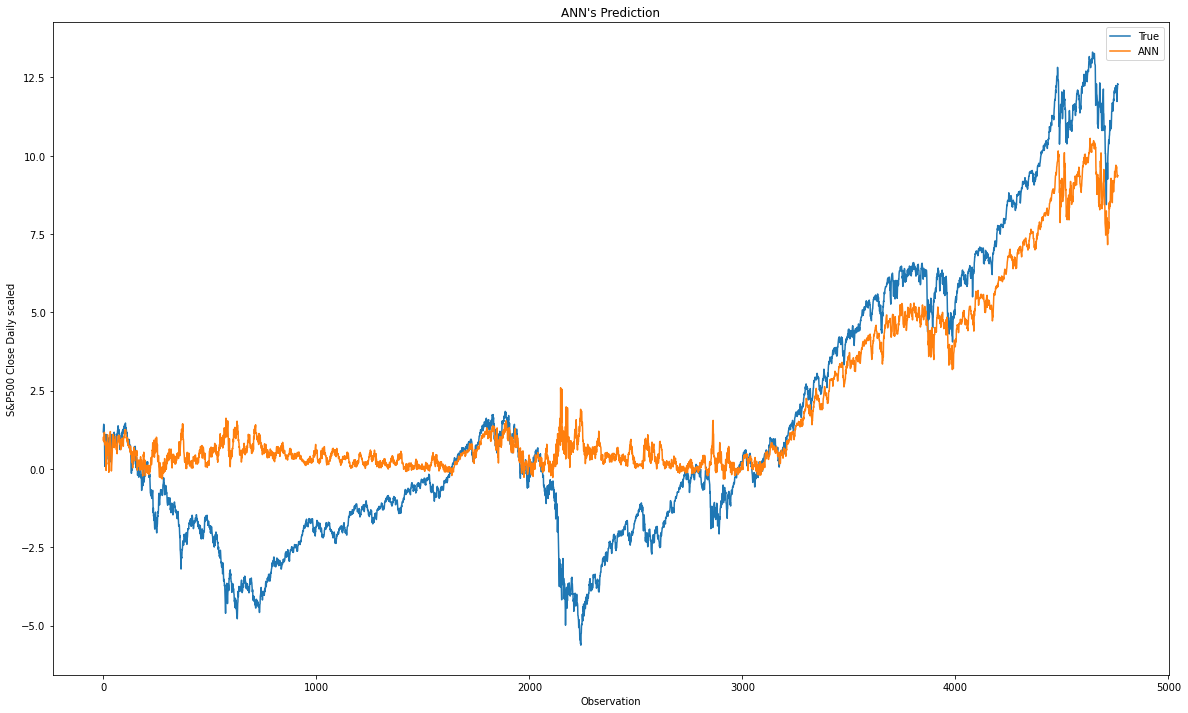

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ann, label='ANN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('S&P500 Close Daily scaled')
plt.legend()
plt.show()